In [1]:
import pandas as pd
import seaborn as sn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import plotly
import plotly.express as px 

## Sources
Data for European countries was recovered from: https://ourworldindata.org/covid-deaths

Data for US states was recovered from : https://github.com/nytimes/covid-19-data

And calculated by million using census data from : https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_1873399417

Visualization references:
https://plotly.com/python-api-reference/generated/plotly.express.bar.html

# US Data

In [3]:
us_df=pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv').rename(columns={
    'cases':'total_cases','deaths':'total_deaths'})
us_df[:2]

,date,state,fips,total_cases,total_deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0


In [4]:
us_df.date=pd.to_datetime(us_df.date, infer_datetime_format=True)
print(us_df.date.min(), 'to', us_df.date.max())
print('NA:',us_df.isna().sum())

2020-01-21 00:00:00 to 2020-10-04 00:00:00
NA: date            0
state           0
fips            0
total_cases     0
total_deaths    0
dtype: int64


In [5]:
# Calculating new cases and new death per state over time
us_df['new_deaths']=us_df.groupby('state')['total_deaths'].diff(periods=1)
us_df['new_cases']=us_df.groupby('state')['total_cases'].diff(periods=1)

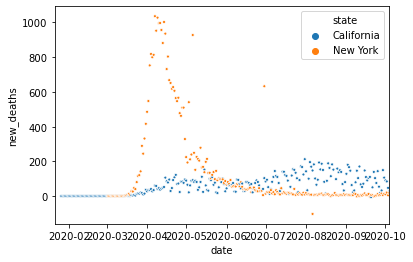

In [6]:
#Visualize new deaths for given states
sn.scatterplot(x='date',y='new_deaths',hue='state',marker='.',
               data=us_df[us_df.state.isin(['California','New York'])]);
plt.xlim(min(us_df.date), max(us_df.date));

In [7]:
#merge state population
us_census=pd.read_csv('nst-est2019-alldata.csv')[['NAME','CENSUS2010POP']]
us_df=pd.merge(left=us_df, right=us_census,how='left',left_on='state', right_on='NAME')
us_census[:2]

,NAME,CENSUS2010POP
0,United States,308745538
1,Northeast Region,55317240


In [8]:
#keep only states with more than 1M people
print(us_df.groupby('state').size().shape)
us_df=us_df[us_df.CENSUS2010POP>1000000] 
print(us_df.groupby('state').size().shape)

(55,)
(44,)


In [9]:
#Remove missing values
print(us_df.isna().sum())
print(us_df[us_df.NAME.isna()==True][:2])
us_df=us_df[us_df.NAME.isna()==False].reset_index().drop(columns='index')

date              0
state             0
fips              0
total_cases       0
total_deaths      0
new_deaths       44
new_cases        44
NAME              0
CENSUS2010POP     0
dtype: int64
Empty DataFrame
Columns: [date, state, fips, total_cases, total_deaths, new_deaths, new_cases, NAME, CENSUS2010POP]
Index: []


In [10]:
#cases/death per million
us_df['total_cases_per_million']=us_df.total_cases/us_df.CENSUS2010POP*1000000
us_df['total_deaths_per_million']=us_df.total_deaths/us_df.CENSUS2010POP*1000000
us_df['new_cases_per_million']=us_df.new_cases/us_df.CENSUS2010POP*1000000
us_df['new_deaths_per_million']=us_df.new_deaths/us_df.CENSUS2010POP*1000000
us_df[:2]

,date,state,fips,total_cases,total_deaths,new_deaths,new_cases,NAME,CENSUS2010POP,total_cases_per_million,total_deaths_per_million,new_cases_per_million,new_deaths_per_million
0,2020-01-21,Washington,53,1,0,NaN,NaN,Washington,6724540.0,0.148709,0.0,NaN,NaN
1,2020-01-22,Washington,53,1,0,0.0,0.0,Washington,6724540.0,0.148709,0.0,0.0,0.0


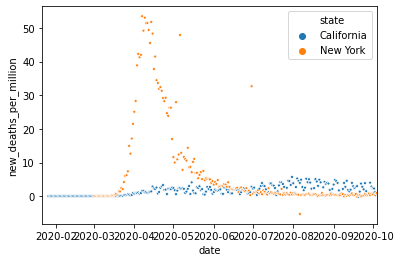

In [11]:
#Same graph as above but adjusted per million
sn.scatterplot(x='date',y='new_deaths_per_million',hue='state',marker='.',
               data=us_df[us_df.state.isin(['California','New York'])]);
plt.xlim(min(us_df.date), max(us_df.date));

In [12]:
us_df['new_cases_per_million_week_sum'] = us_df.groupby(
    'state').new_cases_per_million.rolling(7).sum().reset_index(0,drop=True).round(2)
us_df['new_deaths_per_million_week_sum'] = us_df.groupby(
    'state').new_deaths_per_million.rolling(7).sum().reset_index(0,drop=True).round(2)
us_df['new_cases_per_million_week_sum'] = us_df['new_cases_per_million_week_sum'].fillna(value=0)
us_df['new_deaths_per_million_week_sum'] = us_df['new_deaths_per_million_week_sum'].fillna(value=0)
#rank states by death by date
# us_df['rank_death_by_date'] = us_df.groupby('date')['new_deaths_per_million_week_sum'].rank()
us_df[:2]

,date,state,fips,total_cases,total_deaths,new_deaths,new_cases,NAME,CENSUS2010POP,total_cases_per_million,total_deaths_per_million,new_cases_per_million,new_deaths_per_million,new_cases_per_million_week_sum,new_deaths_per_million_week_sum
0,2020-01-21,Washington,53,1,0,NaN,NaN,Washington,6724540.0,0.148709,0.0,NaN,NaN,0.0,0.0
1,2020-01-22,Washington,53,1,0,0.0,0.0,Washington,6724540.0,0.148709,0.0,0.0,0.0,0.0,0.0


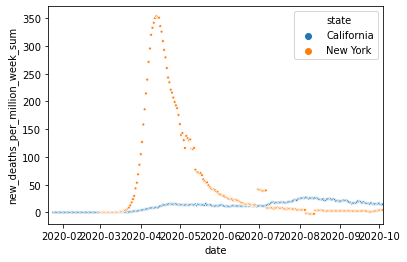

In [13]:
#Same graph as above but weekly sum of new deaths
sn.scatterplot(x='date',y='new_deaths_per_million_week_sum',hue='state',marker='.',
               data=us_df[us_df.state.isin(['California','New York'])]);
plt.xlim(min(us_df.date), max(us_df.date));

In [14]:
us_df.to_csv('us_df.csv',index=False)

## EU data

In [15]:
#world_df=pd.read_csv('owid-covid-data.csv')
world_df=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv').rename(columns={'location':'state'})
print(world_df.shape)
world_df.date= pd.to_datetime(world_df.date, infer_datetime_format=True)  
world_df=world_df.sort_values('date')
world_df[:2]

(48169, 41)


,iso_code,continent,state,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
33412,NPL,Asia,Nepal,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,2442.804,15.0,260.797,7.26,9.5,37.8,47.782,0.3,70.78,0.574
4625,BHR,Asia,Bahrain,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,43290.705,NaN,151.689,16.52,5.8,37.6,NaN,2.0,77.29,0.846


In [16]:
eu_df=world_df[world_df.continent=='Europe']
print(eu_df.groupby('state').size().shape)
eu_df=eu_df[eu_df.population>1000000] #keep only countries with more than 1M people
print(eu_df.groupby('state').size().shape)

(51,)
(36,)


In [17]:
eu_df['new_cases_per_million_week_sum'] = eu_df.groupby(
    'state').new_cases_per_million.rolling(7).sum().reset_index(0,drop=True).round(2)
eu_df['new_deaths_per_million_week_sum'] = eu_df.groupby(
    'state').new_deaths_per_million.rolling(7).sum().reset_index(0,drop=True).round(2)
eu_df['new_cases_per_million_week_sum'] = eu_df['new_cases_per_million_week_sum'].fillna(value=0)
eu_df['new_deaths_per_million_week_sum'] = eu_df['new_deaths_per_million_week_sum'].fillna(value=0)
eu_df[:2]

,iso_code,continent,state,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,new_cases_per_million_week_sum,new_deaths_per_million_week_sum
20814,IRL,Europe,Ireland,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,126.459,3.28,23.0,25.7,NaN,2.96,82.30,0.938,0.0,0.0
11251,DEU,Europe,Germany,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,156.139,8.31,28.2,33.1,NaN,8.00,81.33,0.936,0.0,0.0


In [18]:
#rank states by death by date
# eu_df['rank_death_by_date'] = eu_df.groupby('date')['new_deaths_per_million_week_sum'].rank()

In [19]:
eu_df.to_csv('eu_df.csv',index=False)

# Merge and visualize

In [20]:
eu_df['Region']='Europe'
us_df['Region']='United States'
keep_columns=['state', 'Region', 'date', 'total_cases', 'total_deaths', 'new_deaths', 
              'new_cases', 'total_cases_per_million', 'total_deaths_per_million', 'new_cases_per_million', 
              'new_deaths_per_million', 'new_cases_per_million_week_sum', 'new_deaths_per_million_week_sum']
useu_df=pd.concat([eu_df[keep_columns],us_df[keep_columns]])
useu_df.date=pd.to_datetime(useu_df.date, infer_datetime_format=True)
useu_df.new_deaths_per_million_week_sum=useu_df.new_deaths_per_million_week_sum.clip(lower=0)
useu_df['rank_death_by_date'] = useu_df.groupby('date')['new_deaths_per_million_week_sum'].rank(
    ascending=False,method='first')
useu_df.to_csv('useu_df.csv',index=False)

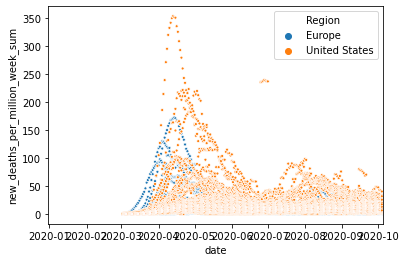

In [21]:
#Same graph as above but weekly sum of new deaths
sn.scatterplot(x='date',y='new_deaths_per_million_week_sum',hue='Region',marker='.',
               data=useu_df[useu_df.date>'2020-03']);
plt.xlim(min(useu_df.date), max(useu_df.date));

In [22]:
# useu_df['date_str']=useu_df.date.strftime('%Y-%m-%d')
useu_df['timestamp'] = useu_df.date.apply(lambda x: x.date()).apply(str)
useu_df

,state,Region,date,total_cases,total_deaths,new_deaths,new_cases,total_cases_per_million,total_deaths_per_million,new_cases_per_million,new_deaths_per_million,new_cases_per_million_week_sum,new_deaths_per_million_week_sum,rank_death_by_date,timestamp
20814,Ireland,Europe,2019-12-31,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,1.0,2019-12-31
11251,Germany,Europe,2019-12-31,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,2.0,2019-12-31
37255,Russia,Europe,2019-12-31,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,3.0,2019-12-31
33132,Norway,Europe,2019-12-31,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,4.0,2019-12-31
26783,Lithuania,Europe,2019-12-31,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,5.0,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,Utah,United States,2020-10-04,77618.0,478.0,2.0,1387.0,28082.933986,172.944967,501.829852,0.723619,2533.39,9.05,40.0,2020-10-04
9620,Virginia,United States,2020-10-04,151870.0,3273.0,3.0,1067.0,18981.320391,409.072639,133.357930,0.374952,715.66,14.25,24.0,2020-10-04
9621,Washington,United States,2020-10-04,93527.0,2238.0,0.0,367.0,13908.311944,332.810869,54.576224,0.000000,550.97,6.25,49.0,2020-10-04
9622,West Virginia,United States,2020-10-04,16628.0,358.0,1.0,160.0,8973.585451,193.200841,86.346745,0.539667,690.77,12.95,30.0,2020-10-04


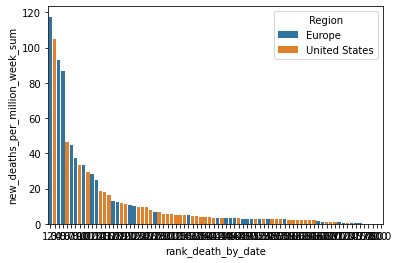

In [23]:
ax = sn.barplot(x="rank_death_by_date", y="new_deaths_per_million_week_sum", hue="Region",
                 data=useu_df[useu_df.timestamp=='2020-04-01'], dodge=False)

In [28]:
useu_df_graph=useu_df[(useu_df.date>'2020-03-15') & (useu_df.date<'2020-09-20')][[
    'Region','state','timestamp','new_cases_per_million_week_sum',
             'new_deaths_per_million_week_sum','rank_death_by_date']]
useu_df_graph=useu_df_graph.sort_values(['timestamp','rank_death_by_date'])
fig = px.bar(data_frame=useu_df_graph, x='rank_death_by_date', y="new_deaths_per_million_week_sum", color='Region',
      animation_frame='timestamp', hover_data=['state'],
             color_discrete_sequence=["royalblue","orangered"],
             range_y=[0,useu_df_graph.new_deaths_per_million_week_sum.max()*1.1],
             labels={
                     "rank_death_by_date": "Rank",
                     "new_deaths_per_million_week_sum": "Death per week",
                 },
                title="COVID-19: Death per million inhabitant by country/state")
fig.update_xaxes(tickangle=45, tickfont=dict(family='Rockwell', size=12),autorange="reversed")
fig.show()

In [29]:
useu_df_graph[useu_df_graph.timestamp=='2020-05-01'][['state','Region','new_deaths_per_million_week_sum',
                                                      'rank_death_by_date']]

,state,Region,new_deaths_per_million_week_sum,rank_death_by_date
2742,New Jersey,United States,218.50,1.0
2734,Massachusetts,United States,177.16,2.0
2721,Connecticut,United States,160.88,3.0
2744,New York,United States,159.05,4.0
20936,Ireland,Europe,88.70,5.0
...,...,...,...,...
26905,Lithuania,Europe,1.84,76.0
44451,Ukraine,Europe,1.69,77.0
40377,Slovakia,Europe,1.46,78.0
17964,Greece,Europe,1.44,79.0


In [30]:
import plotly.io as pio
pio.write_html(fig, file='COVID-19 New death per million inhabitant by state.html', auto_open=True)

In [31]:
import chart_studio
chart_studio.tools.set_credentials_file(username='', api_key='')

In [32]:
import chart_studio.plotly as cs
cs.plot(fig, filename = 'COVID-19 New death per million inhabitant by state', auto_open=True)

'https://plotly.com/~kleempoe/1/'